In [25]:
import torch
import torch.nn as nn
from torch.nn import Conv2d, MaxPool2d, Linear, ReLU
from torch import flatten
import torch.optim as optim
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

## Loading Data

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

train_set = datasets.MNIST(
    root="./Datasets",
    download=True,
    train=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(0, 1)])
)

test_set = datasets.MNIST(
    root='./Datasets',
    download=True,
    train=False,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(0, 1)])
)

cpu


## Creating DataLoader

In [27]:
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=256, shuffle=True)

## Defining Model

In [28]:
class Model(nn.Module):
    def __init__(self, in_channels, out_classes):
        super(Model, self).__init__()
        # (CONV => RELU => POOL) * 2 => FC => RELU => FC => SOFTMAX
        
        # First: CONV => RELU => POOL
        self.conv1 = Conv2d(in_channels=in_channels, out_channels=20, kernel_size=(5, 5))
        self.relu1 = ReLU()
        self.maxPool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        # Second: CONV => RELU => POOL
        self.conv2 = Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5))
        self.relu2 = ReLU()
        self.maxPool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        # FC => RELU
        self.fullyConnected1 = Linear(in_features=800, out_features=500)
        self.relu3 = ReLU()
        
        # FC => SOFTMAX
        
        self.fullyConnected2 = Linear(in_features=500, out_features=out_classes)
        self.logSoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxPool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxPool2(x)
        
        x = flatten(x, start_dim=1)
        x = self.fullyConnected1(x)
        x = self.relu3(x)
        
        x = self.fullyConnected2(x)
        out = self.logSoftmax(x)
        
        return out

In [29]:
# Do not change this cell
def caluculate_acc(data, model, length):
  model.eval()
  acc = 0
  for images, label in data:
    with torch.no_grad():
      images = images.to(device)
      label = label.to(device)
      yp = model(images)
      yp = torch.nn.functional.softmax(yp, dim=1)
      yp = torch.argmax(yp, 1)
      acc += torch.sum(yp == label)
  return acc / length

## Training Steps

In [30]:
# Do not change this cell
def train_one_epoch(model, data, optimizer, criterion, length):
  model.train()
  acc = 0
  for images, labels in data:
    imgs = torch.autograd.Variable(images).to(device)
    label = torch.autograd.Variable(labels).to(device)
    optimizer.zero_grad()
    yp = model(imgs)
    loss = criterion(yp, label)
    loss.backward()
    optimizer.step()
    yp = torch.argmax(yp, 1)
    acc += torch.sum(yp == label)
  return loss.item(), acc / length

In [31]:
# Defining hyperparameters
hparams = {'batch_size': 256, 'learning_rate': 2e-3}

# Defining model
model = Model(in_channels=1, out_classes=10)
model.to(device)

# Defining optimizer
optimizer = optim.Adam(model.parameters(), lr=hparams['learning_rate'])

# Defining loss
criterion = nn.CrossEntropyLoss()

# model summary
summary(model, input_size=(1, 28, 28), batch_size=hparams['batch_size'])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [256, 20, 24, 24]             520
              ReLU-2          [256, 20, 24, 24]               0
         MaxPool2d-3          [256, 20, 12, 12]               0
            Conv2d-4            [256, 50, 8, 8]          25,050
              ReLU-5            [256, 50, 8, 8]               0
         MaxPool2d-6            [256, 50, 4, 4]               0
            Linear-7                 [256, 500]         400,500
              ReLU-8                 [256, 500]               0
            Linear-9                  [256, 10]           5,010
       LogSoftmax-10                  [256, 10]               0
Total params: 431,080
Trainable params: 431,080
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.77
Forward/backward pass size (MB): 66.68
Params size (MB): 1.64
Estimated 

In [32]:
# training process
val_accs = []
accs = []
best_acc = 0
for e in tqdm(range(20)):
  accs.append(train_one_epoch(model, train_loader, optimizer, criterion, len(train_set))[1].item())
  val_accs.append(caluculate_acc(test_loader, model, len(test_set)).item())
  if best_acc < val_accs[-1]:
    torch.save(model, "model.h5")
    best_Acc = val_accs[-1]
  
  # just a way to avoid pverfitting
  if val_accs[-1] > 0.99 and accs[-1] > 0.99:
    break

  0%|          | 0/20 [00:00<?, ?it/s]

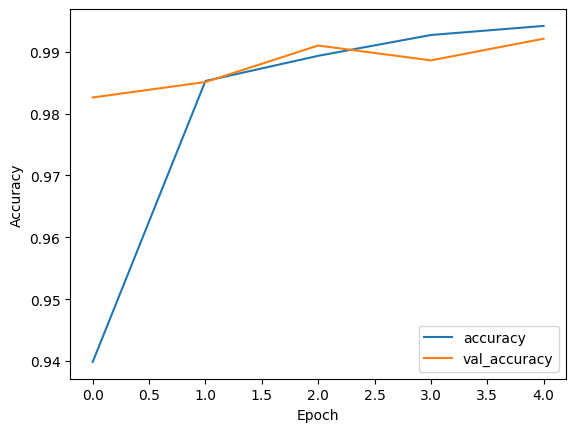

In [33]:
plt.plot(accs, label='accuracy')
plt.plot(val_accs, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show();

In [34]:
caluculate_acc(test_loader, model, len(test_set)).item(), caluculate_acc(train_loader, model, len(train_set)).item()

(0.9921000003814697, 0.9968500137329102)